<a href="https://colab.research.google.com/github/project-ida/metal-hydrides/blob/20250113-h-pd-adsorption/h-adsorption-onto-pd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href="https://nbviewer.org/github/project-ida/metal-hydrides/blob/20250113-h-pd-adsorption/h-adsorption-onto-pd.ipynb" target="_parent"><img src="https://nbviewer.org/static/img/nav_logo.svg" alt="Open In nbviewer" width="100"/></a>

# Hydrogen adsorption onto palladium

The purpose of this notebook is to create code that can simulate the initial stages of molecular hydrogen (or deuterium) gas being absorbed into a palladium lattice.

The full details of this process are very complicated and so it's not the ambition of this first notebook to include all possible effects. The intention of this notebook is to balance physical realism with computational tractability with the ultimate goal to create compelling visualisations that make communicating the physics much easier.

This simulation is part of a group of simulations designed to tackle different part of the hydrogen-palladium system. For example, another simulation deals with diffusion of atomic hydrogen within the palladium lattice. As such, we'll make use of data formats and functions that might seem overkill/sub-optimal for the gas simulation but they keep consistency across the group of simulations.


In [ ]:
# RUN THIS IF YOU ARE USING GOOGLE COLAB
import sys
import os
!pip install periodictable
!git clone https://github.com/project-ida/metal-hydrides.git
sys.path.insert(0,'/content/metal-hydrides')
os.chdir('/content/metal-hydrides')

In [61]:
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from itertools import combinations
from periodictable.formulas import formula as chemical_formula
import random
from plotly.offline import init_notebook_mode

# Initialize offline mode for notebooks
init_notebook_mode(connected=True)

In [2]:
dalton_to_kg = 1.66053906660e-27  # kg per amu

## The lattice

When a gas molecule gets close enough to a surface Pd atom, we're going to need to start "attaching" it in some way. This means that we need to have an awareness of the lattice atoms. We're also going to need to create a simulation "box" inside of which we're going to be moving the gas molecules around. This box depends on how big the lattice is - once again we need to know where the lattice atoms are.

We've defined the lattice in a `.in` file whose structures is inspired by [Quantum Espresso's SCF input files](https://pranabdas.github.io/espresso/hands-on/scf). It needs a special function to read the data and output what we need. What's most important for this simulation is
- The positions of all the atoms (in crystal coordinates)
- The size of a unit cell (in Å)

> Note: when using crystal coordinates, each atomic position is specified as a fraction of the unit cell dimensions along the lattice vectors

In [3]:
def parse_atomic_positions_and_identifiers(filename):
    """
    Parses a file containing atomic structure data and extracts atomic positions, 
    cell parameters, atomic type identifiers, and bond information.

    The input file is expected to contain sections with specific headers:
    - `ATOMIC_POSITIONS crystal`: Specifies atomic positions in fractional coordinates.
    - `CELL_PARAMETERS angstrom`: Specifies the cell parameters in angstrom units.
    - `ATOMIC_TYPE_IDENTIFIERS`: Provides a mapping of atomic type indices to atomic species names.
    - `BONDS`: Defines bond information, with each bond represented by two sets of 3D coordinates.

    Any lines starting with `#` or unrelated sections (e.g., `ATOMIC_SPECIES`) 
    are ignored during parsing.

    Args:
        filename (str): Path to the file containing atomic structure data.

    Returns:
        tuple:
            - `atomic_positions` (list of tuples): Each tuple contains an atomic label 
              (str) and its fractional coordinates (x, y, z) as floats.
              Example: [("H", 0.0, 0.0, 0.0), ("O", 0.5, 0.5, 0.5)].
            - `cell_parameters` (numpy.ndarray): A 3x3 array representing the lattice 
              vectors of the unit cell in angstrom units.
              Example: [[a1, a2, a3], [b1, b2, b3], [c1, c2, c3]].
            - `identifiers` (list of tuples): Each tuple contains an atomic type index 
              (int) and the corresponding atomic species name (str).
              Example: [(1, "H"), (2, "O")].
            - `bonds` (list of lists): Each bond is represented as a list of two sets 
              of 3D coordinates (start and end points) in angstrom units.
              Example: [[[x1, y1, z1], [x2, y2, z2]], ...].

    Example:
        atomic_positions, cell_parameters, identifiers, bonds = parse_atomic_positions_and_identifiers("input_file.txt")
    """
    with open(filename, 'r') as f:
        lines = f.readlines()

    atomic_positions = []
    cell_parameters = []
    identifiers = []
    bonds = []
    
    is_positions = False
    is_cell = False
    is_identifiers = False
    is_bonds = False

    # Parse the file
    for line in lines:
        if "ATOMIC_POSITIONS crystal" in line:
            is_positions = True
            continue
        elif "CELL_PARAMETERS angstrom" in line:
            is_positions = False
            is_cell = True
            continue
        elif "ATOMIC_TYPE_IDENTIFIERS" in line:
            is_cell = False
            is_identifiers = True
            continue
        elif "BONDS" in line:
            is_identifiers = False
            is_bonds = True
            continue
        elif "ATOMIC_SPECIES" in line or "#" in line:
            is_cell = False
            is_identifiers = False
            is_bonds = False

        if is_positions:
            parts = line.split()
            if len(parts) == 4:
                atomic_positions.append((parts[0], float(parts[1]), float(parts[2]), float(parts[3])))
        elif is_cell:
            parts = line.split()
            if len(parts) == 3:
                cell_parameters.append([float(p) for p in parts])
        elif is_identifiers:
            parts = line.split()
            if len(parts) >= 2:
                identifiers.append((int(parts[0]), parts[1])) 
        elif is_bonds:
            parts = line.split()
            if len(parts) == 6:
                bonds.append([
                    [float(parts[0]), float(parts[1]), float(parts[2])],
                    [float(parts[3]), float(parts[4]), float(parts[5])]
                ])

    return atomic_positions, np.array(cell_parameters), identifiers, bonds

In [4]:
pd_positions, cell_parameters, identifiers, bonds = parse_atomic_positions_and_identifiers("data/pd-100.in")

Let's look at the first 10 atomic positions to get a sense of the format - remembering the units are "crystal coordinates".

In [5]:
print("\n".join(map(str, pd_positions[:10])))

('Pd', 0.0, 0.0, 0.0)
('Pd', 0.5, 0.5, 0.0)
('Pd', 0.5, 0.0, 0.5)
('Pd', 0.0, 0.5, 0.5)
('Pd', 0.0, 0.0, 1.0)
('Pd', 0.5, 0.5, 1.0)
('Pd', 0.5, 0.0, 1.5)
('Pd', 0.0, 0.5, 1.5)
('Pd', 0.0, 0.0, 2.0)
('Pd', 0.5, 0.5, 2.0)


We can see the $\rm Pd$ lattice constant $a \approx 3.89 \, Å$ from the "cell parameters" that define the [conventional unit cell](https://en.wikipedia.org/wiki/Unit_cell#Conventional_cell).

In [6]:
print(cell_parameters)

[[3.89 0.   0.  ]
 [0.   3.89 0.  ]
 [0.   0.   3.89]]


It's going to be helpful to be able to switch between angstroms and crystal coordinates so let's make a convenience function for this:

In [7]:
def angstrom_to_crystal(length_angstrom, cell_parameters):
    cell_lengths = np.linalg.norm(cell_parameters, axis=0)
    length_crystal = length_angstrom / cell_lengths.mean()  # Assume isotropic cell
    return length_crystal

Let's check it works by using the lattice constant $a \approx 3.89 \, Å$ and see if it returns 1.

In [8]:
angstrom_to_crystal(3.89, cell_parameters)

1.0

Now let's visualise the lattice in 3D. 

We're going to reverse the usual direction of the $z$-coordinate so that positive $z$ is moving into the lattice and negative $z$ is the space above the surface. The surface is defined at $z=0$.

In [9]:
def plot_lattice(atom_positions, elements=None, xlim=(-0.5, 2.5), ylim=(-0.5, 3.5), zlim=(2.5, -2.5), export=False, marker_color_map=None, marker_size_map=None):
    """
    Plot a 3D lattice of atomic positions with customised marker styles for specific atom types.

    Parameters:
    ----------
    atom_positions : list of tuples
        A list of atomic positions, where each element is a tuple of the form 
        (atom_type, x, y, z). For example:
        [('Pd', 0.5, 0.5, 0.0), ('H', 1.0, 1.0, 1.0), ('O', 0.2, 0.2, 0.2)].

    elements : list of strings, optional
        The label of the atomic elements that you want to be ploted, e.g. ["Pd", "H"].
        This will be inferred from the atom_positions label if not specified.
        This is useful for cases where you want a legend to show for a particular elements
        even if there is no data provided for it.

    xlim : tuple of floats, optional
        The range of the x-axis in the plot, specified as (min, max).
        Default is (-0.5, 2.5).

    ylim : tuple of floats, optional
        The range of the y-axis in the plot, specified as (min, max).
        Default is (-0.5, 3.5).

    zlim : tuple of floats, optional
        The range of the z-axis in the plot, specified as (min, max).
        Default is (2.5, -2.5).

    export : bool, optional
        If True, the plot is configured to autosize for exporting to an HTML file using 
        `fig.write_html("filename.html")`. If False, the plot is displayed with fixed 
        dimensions (900x700). Default is False.

    marker_color_map : dict, optional
        A dictionary mapping atom types to marker colors. For example:
        {'Pd': 'dimgrey', 'H': 'darkorange', 'D': 'darkorange'}.
        If not provided, a default color map is used.

    marker_size_map : dict, optional
        A dictionary mapping atom types to marker sizes. For example:
        {'Pd': 6, 'H': 3, 'D': 3}.
        If not provided, default sizes are used.

    Returns:
    -------
    fig : plotly.graph_objects.Figure
        A Plotly 3D scatter plot showing the atomic lattice. Each atom type is plotted 
        with customised marker size and color:
        - 'Pd': Marker size 6, color 'dimgrey'.
        - 'H': Marker size 3, color 'darkorange'.
        - All other atom types: Marker size 4, color 'blue'.

    Notes:
    -----
    - The aspect ratio of the plot is automatically calculated based on the specified 
      axis ranges to ensure proper visualisation.
    - The function is designed to handle multiple atom types, grouping atoms by type 
      and assigning unique styles based on predefined rules.

    Example:
    -------
    >>> atom_positions = [
    ...     ('Pd', 0.5, 0.5, 0.0), ('Pd', 1.5, 1.5, 1.0),
    ...     ('H', 0.0, 0.0, 0.0), ('H', 1.0, 1.0, 1.0),
    ...     ('O', 0.2, 0.2, 0.2), ('C', 0.3, 0.3, 0.3)
    ... ]
    >>> fig = plot_lattice(atom_positions, xlim=(-1, 2), ylim=(-1, 2), zlim=(-1, 2), export=False)
    >>> fig.show()
    """

    default_color = 'purple'  # Default color for markers
    
    # Define the default color map for known atom types
    default_marker_color_map = {
        'Pd': 'dimgrey',
        'Ti': 'dimgrey',
        'H': 'darkorange',
        'D': 'darkorange',
        'O': 'blue',
    }

    # Merge user-provided marker_color_map with the default map
    if marker_color_map:
        # User-defined map overrides default map for any overlapping keys
        marker_color_map = {**default_marker_color_map, **marker_color_map}
    else:
        # Use the default map if no user map is provided
        marker_color_map = default_marker_color_map

    default_size = 4  # Default size for markers
    
    # Define the default size map for known atom types
    default_marker_size_map = {
        'Pd': 6,
        'Ti': 6,
        'H': 3,
        'D': 3,
        'O': 4
    }

    # Merge user-provided marker_size_map with the default map
    if marker_size_map:
        # User-defined map overrides default map for any overlapping keys
        marker_size_map = {**default_marker_size_map, **marker_size_map}
    else:
        # Use the default map if no user map is provided
        marker_size_map = default_marker_size_map
        

    # Gather together data for different atom_types using "elements" (if provided) to generate lists
    # of data that will be plotted shortly
    atom_dict = {}
    if elements is not None:
        for element in elements:
            atom_dict[element] = []
            
    # Extract unique atom types if not provided in parameters. Then extract
    # their positions from lists of tuples like ('Pd', 0.5, 0.5, 0.0)
    for atom in atom_positions:
        atom_type = atom[0]
        position = atom[1:]
        if atom_type not in atom_dict:
            atom_dict[atom_type] = []
        atom_dict[atom_type].append(position)

    # Data list for the final plot
    data = []

    for atom_type, positions in atom_dict.items():
        positions_array = np.array(positions)

        marker_color = marker_color_map.get(atom_type, default_color)
        marker_size = marker_size_map.get(atom_type, default_size)

        if positions_array.size > 0:
            # Add scatter for the current atom type
            data.append(go.Scatter3d(
                x=positions_array[:, 0],
                y=positions_array[:, 1],
                z=positions_array[:, 2],
                mode='markers',
                marker=dict(size=marker_size, color=marker_color),
                name=atom_type,
                showlegend=True
            ))
        else:
            # Add an empty trace
            data.append(go.Scatter3d(
                x=[None],
                y=[None],
                z=[None],
                mode='markers',
                marker=dict(size=marker_size, color=marker_color),
                name=atom_type,
                showlegend=True
            ))

    # Calculate the span of each axis
    x_span = abs(xlim[1] - xlim[0])
    y_span = abs(ylim[1] - ylim[0])
    z_span = abs(zlim[1] - zlim[0])

    # Create manual aspect ratio that depends on the range of values we want to plot
    max_span = max(x_span, y_span, z_span)
    aspect_ratio = dict(
        x=x_span / max_span,
        y=y_span / max_span,
        z=z_span / max_span
    )

    if export == True:
        # For HTML export via fig.write_html("file_name.html"), we want the plot to autosize based in the screensize
        fig = go.Figure(
                    data=data,
                    layout=go.Layout(
                        autosize=True,
                        scene=dict(
                            xaxis=dict(nticks=4, range=xlim),
                            yaxis=dict(nticks=4, range=ylim),
                            zaxis=dict(nticks=4, range=zlim),
                            aspectmode='manual',
                            aspectratio=aspect_ratio
                        )
                    )
        )
        
    else:
        fig = go.Figure(
                data=data,
                layout=go.Layout(
                    scene=dict(
                        xaxis=dict(nticks=4, range=xlim),
                        yaxis=dict(nticks=4, range=ylim),
                        zaxis=dict(nticks=4, range=zlim),
                        aspectmode='manual',
                        aspectratio=aspect_ratio
                    ),
                    width=900,
                    height=700,
                    margin=dict(l=50, r=50, t=50, b=50)
                )
        )
      

    return fig


In [10]:
plot_lattice(pd_positions)

From the figure above, we can see a convenient simulation "box" above the surface ($-2<z<0$) for us to be moving the gas molecules around in. We'll create a function to automatically extract limits of the box.

In [11]:
def calculate_gas_limits(lattice_positions, space_above_surface):
    """
    Calculate the simulation box limits from lattice positions, incorporating a specified space above the surface.

    Parameters:
    ----------
    lattice_positions : list of tuples
        A list of atomic positions, where each element is a tuple of the form 
        (atom_type, x, y, z). For example:
        [('Pd', 0.5, 0.5, 0.0), ('H', 1.0, 1.0, 1.0), ('O', 0.2, 0.2, 0.2)].

    space_above_surface : float
        The amount of space (in the same units as the coordinates) to include 
        above the surface. This defines the lower limit of the z-axis in the 
        simulation box as `-space_above_surface`.

    Returns:
    -------
    limits : dict
        A dictionary containing the minimum and maximum values for each axis:
        - 'x': (x_min, x_max)
        - 'y': (y_min, y_max)
        - 'z': (-space_above_surface, z_min)
        For example:
        {'x': (0.0, 2.0), 'y': (0.0, 2.5), 'z': (-5.0, 0.0)}


    Example:
    -------
    >>> lattice_positions = [
    ...     ('Pd', 0.5, 0.5, 0.0), ('Pd', 1.5, 1.5, -0.5),
    ...     ('H', 0.0, 0.0, -0.1), ('H', 1.0, 1.0, -0.2)
    ... ]
    >>> space_above_surface = 5.0
    >>> limits = calculate_gas_limits(lattice_positions, space_above_surface)
    >>> print(limits)
    {'x': (0.0, 1.5), 'y': (0.0, 1.5), 'z': (-5.0, -0.5)}
    """

    x_coords = [x for _, x, _, _ in lattice_positions]
    y_coords = [y for _, _, y, _ in lattice_positions]
    z_coords = [z for _, _, _, z in lattice_positions]
    
    x_min, x_max = min(x_coords), max(x_coords)
    y_min, y_max = min(y_coords), max(y_coords)
    z_min, z_max = min(z_coords), max(z_coords)

    return {'x': (x_min, x_max), 'y': (y_min, y_max), 'z': (-space_above_surface, z_min)}

In [12]:
gas_limits = calculate_gas_limits(pd_positions, 2.0)
gas_limits

{'x': (0.0, 2.0), 'y': (0.0, 3.0), 'z': (-2.0, 0.0)}

We're going to need to be able to easily identify the surface atoms because these are the atoms that the gas molecules will interact with.

In [13]:
def extract_surface_atoms(lattice_positions, species=None):
    """
    Extract surface atoms from a list of atomic positions, optionally filtering by atom species.

    Parameters:
    ----------
    lattice_positions : list of tuples
        A list of atomic positions, where each element is a tuple of the form 
        (atom_type, x, y, z). For example:
        [('Pd', 0.5, 0.5, 0.0), ('H', 1.0, 1.0, 1.0), ('O', 0.2, 0.2, 0.0)].

    species : str, optional
        The label of the atomic species to filter by (e.g., 'Pd'). If not specified, 
        all atom types at z=0.0 are returned.

    Returns:
    -------
    surface_atoms : list of tuples
        A list of atoms that are located on the surface, identified by their 
        z-coordinate being exactly 0.0. If a species is specified, only atoms of 
        that type are included. Each element is a tuple of the form (atom_type, x, y, z).

    Example:
    -------
    >>> lattice_positions = [
    ...     ('Pd', 0.5, 0.5, 0.0), ('Pd', 1.5, 1.5, 1.0),
    ...     ('H', 0.0, 0.0, 0.0), ('H', 1.0, 1.0, 1.0),
    ...     ('O', 0.2, 0.2, 0.0)
    ... ]
    >>> # Get all atoms on the surface
    >>> surface_atoms = extract_surface_atoms(lattice_positions)
    >>> print(surface_atoms)
    [('Pd', 0.5, 0.5, 0.0), ('H', 0.0, 0.0, 0.0), ('O', 0.2, 0.2, 0.0)]

    >>> # Get only 'Pd' atoms on the surface
    >>> surface_atoms_pd = extract_surface_atoms(lattice_positions, species='Pd')
    >>> print(surface_atoms_pd)
    [('Pd', 0.5, 0.5, 0.0)]
    """
    if species:
        return [atom for atom in lattice_positions if atom[0] == species and atom[3] == 0.0]
    return [atom for atom in lattice_positions if atom[3] == 0.0]


In [14]:
surface_pd_atoms = extract_surface_atoms(pd_positions, "Pd")

In [15]:
plot_lattice(surface_pd_atoms)

## The gas

How many gas molecules are going to be present in the simulation box? We first need to get the volume of the box.

In [16]:
cell_volume = np.abs(np.linalg.det(cell_parameters))
num_cells_x = gas_limits['x'][1] - gas_limits['x'][0]
num_cells_y = gas_limits['y'][1] - gas_limits['y'][0]
num_cells_z = gas_limits['z'][1] - gas_limits['z'][0]
total_volume = cell_volume * num_cells_x * num_cells_y * num_cells_z
print(f"{total_volume} Å³")


706.366428 Å³


If we take the number density of air at standard temperature and pressure $n\approx 2.5\times 10^{25} \,  \rm m^{-3}$, then the number of molecules in the simulation box is going to be on the order of:

In [17]:
2.5e25 * total_volume * 1e-30 # Convert Å^3 to m^3

0.017659160700000003

We have less than a single particle in the simulation box at any one time. 

This means that we don't need to take into account collisions between gas molecules.

It also means that we have to use some probability when generating the gas molecules. More specifically, when a gas molecule leaves the simulation box we should not immediately bring in a new one. We should instead wait for some time in order for the average density (over time) to approach a value consistent with the given temperature and pressure.

Below is a function that generates gas molecule positions in such a probabilistic way. If a molecule is generated, it is positioned at the boundaries of the simulation box away from the lattice surface.

Because the lattice is defined in terms of crystal coordinates, we need to include the `cell_parameters` so that we can calculate volumes in terms of SI units.

In [18]:
def generate_gas_positions(gas_pressure, gas_temperature, gas_limits, cell_parameters, species="H", particle_mass=None):
    """
    Generate initial gas particle positions based on pressure, temperature, and gas limits.
    Positions will be generated near the boundaries: either at z=min or at the extremes of x and y.

    Parameters:
    ----------
    gas_pressure : float
        The pressure of the gas in bar.

    gas_temperature : float
        The temperature of the gas in Celsius.

    gas_limits : dict
        A dictionary defining the limits of the gas box in crystal coordinates. The format is:
        {'x': (x_min, x_max), 'y': (y_min, y_max), 'z': (z_min, z_max)}.

    cell_parameters : numpy.ndarray
        A 3x3 matrix representing the cell parameters in Ångströms.

    species : str, optional
        The chemical formula for the gas particles. Default is "H".

    particle_mass : float, optional
        The mass of the particle in kg. Default is None. If not provided, the mass will
        be determined from the species. This is an expensive operation, so if caling the
        function a lot, it's best to precalculate the mass and use this parameter

    Returns:
    -------
    list of tuples
        A list of tuples representing the generated gas particles, where each tuple is of the form:
        (species, x, y, z).

    Example:
    -------
    >>> gas_pressure = 1.0  # in bar
    >>> gas_temperature = 25.0  # in Celsius
    >>> gas_limits = {'x': (0, 2), 'y': (0, 2), 'z': (-5, 0)}
    >>> cell_parameters = np.array([[3.0, 0.0, 0.0], [0.0, 3.0, 0.0], [0.0, 0.0, 3.0]])  # cubic cell
    >>> gas_positions = generate_gas_positions(gas_pressure, gas_temperature, gas_limits, cell_parameters)
    >>> print(gas_positions)
    [('H', 1.234, 0.567, -5.0), ('H', 2.0, 1.123, -2.5), ...]
    """
    
    k_B = 1.38e-23  # Boltzmann constant in J/K
    dalton_to_kg = 1.66053906660e-27  # kg per amu
    if not particle_mass:
        particle_mass = chemical_formula(species).mass*dalton_to_kg

    # Step 1: Convert pressure and temperature
    pressure_pa = gas_pressure * 1e5  # Convert bar to Pascals
    temperature_k = gas_temperature + 273.15  # Convert Celsius to Kelvin

    # Step 2: Calculate number density
    number_density = pressure_pa / (k_B * temperature_k)  # particles/m^3

    # Step 3: Calculate gas volume in m^3
    cell_volume = np.abs(np.linalg.det(cell_parameters)) * 1e-30  # Convert Å^3 to m^3
    num_cells_x = gas_limits['x'][1] - gas_limits['x'][0]
    num_cells_y = gas_limits['y'][1] - gas_limits['y'][0]
    num_cells_z = gas_limits['z'][1] - gas_limits['z'][0]
    total_volume = cell_volume * num_cells_x * num_cells_y * num_cells_z

    # Step 4: Calculate total number of particles
    expected_particles = number_density * total_volume
    num_particles = int(np.floor(expected_particles))

    # Add a single particle based on fractional probability
    if np.random.random() < (expected_particles - num_particles):
        num_particles += 1

    # Step 5: Generate positions at boundaries
    positions = []
    for _ in range(num_particles):
        # Decide on position type
        if np.random.random() < 0.5:
            # Generate at z=min boundary
            z = gas_limits['z'][0]
            x = np.random.uniform(gas_limits['x'][0], gas_limits['x'][1])
            y = np.random.uniform(gas_limits['y'][0], gas_limits['y'][1])
        else:
            # Generate at extreme x or y boundary
            z = np.random.uniform(gas_limits['z'][0], (gas_limits['z'][0]-gas_limits['z'][1])/2)
            if np.random.random() < 0.5:
                # Extreme x
                x = gas_limits['x'][0] if np.random.random() < 0.5 else gas_limits['x'][1]
                y = np.random.uniform(gas_limits['y'][0], gas_limits['y'][1])
            else:
                # Extreme y
                x = np.random.uniform(gas_limits['x'][0], gas_limits['x'][1])
                y = gas_limits['y'][0] if np.random.random() < 0.5 else gas_limits['y'][1]

        positions.append((species, x, y, z))

    return positions

Let's check how often the function will actually generate a gas molecules

In [19]:
number_mol = []
num_experiments = 1000
pressure  = 1 # bar
H2_mass = chemical_formula("H2").mass*dalton_to_kg
temperature = 25 # C

for n in range(num_experiments):
    tot = 0
    for i in range(100):
        gas_atoms = generate_gas_positions(pressure, temperature, gas_limits, cell_parameters, "H2", H2_mass)
        if len(gas_atoms) != 0:
            tot+=1
    number_mol.append(tot)
    
print(sum(number_mol)/len(number_mol))

1.717


In 100 numerical "experiments" the function generates about 1.7 molecules for every 100 attempts - this is consistent with number densities of a gas at typical temperatures and pressures.

To continue the spirit of physical realism, we need to create particles with the correct distribution of velocities given a specific temperature. Each component of the velocity $v_x$, $v_y$, $v_z$ is distributed according to a Maxwell distribution:

$$f(v_i) = {\sqrt {\frac {m}{2\pi k_{\text{B}}T}}}\,\exp \left(-{\frac {mv_{i}^{2}}{2k_{\text{B}}T}}\right)$$

This is just a standard normal distribution with a standard deviation of:

$$\sigma = \sqrt{\frac{k_B T}{m}}$$

Let's create a function that samples such a normal distribution.

In [20]:
def generate_gas_velocities(num_particles, gas_temperature, cell_parameters, species="H", particle_mass=None):
    """
    Generate initial gas particle velocities based on the Maxwell distrubution and convert to crystal units,
    ensuring that vz is always positive so that the gas molecule is always heading to the lattice
    surface at z=0.
    
    Parameters:
    ----------
    num_particles : int
        The number of gas particles for which velocities need to be generated.
        
    gas_temperature : float
        The temperature of the gas in Celsius.

    cell_parameters : numpy.ndarray
        A 3x3 matrix representing the cell parameters in Ångströms.

    species : str, optional
        The chemical formula for the gas particles. Default is "H".

    particle_mass : float, optional
        The mass of the particle in kg. Default is None. If not provided, the mass will
        be determined from the species. This is an expensive operation, so if caling the
        function a lot, it's best to precalculate the mass and use this parameter


    Returns:
    -------
    list of tuples
        A list of tuples representing the velocities of gas particles in the format (vx, vy, vz) in crystal units per second

    Example:
    -------
    >>> gas_temperature = 25.0  # in Celsius
    >>> cell_parameters = np.array([[3.0, 0.0, 0.0], [0.0, 3.0, 0.0], [0.0, 0.0, 3.0]])  # cubic cell
    >>> num_particles = 5
    >>> velocities = generate_gas_velocities(gas_temperature, cell_parameters, num_particles, "H2")
    >>> print(velocities)
    [(0.123, 0.456, 0.789), (-0.321, 0.654, 0.987), ...]
    """
    
    k_B = 1.38e-23  # Boltzmann constant in J/K
    dalton_to_kg = 1.66053906660e-27  # kg per amu
    if not particle_mass:
        particle_mass = chemical_formula(species).mass*dalton_to_kg

    # Step 1: Convert temperature to Kelvin
    temperature_k = gas_temperature + 273.15

    # Step 2: Calculate the standard deviation for each velocity component
    sigma = np.sqrt(k_B * temperature_k / particle_mass)  # in m/s

    # Step 3: Compute cell length in m for scaling
    cell_parameters_m = cell_parameters * 1e-10 #  Å to m
    cell_lengths_m = np.linalg.norm(cell_parameters_m, axis=0)
    cell_length_m = cell_lengths_m.mean() # Assume isotropic cell

    # Step 4: Generate velocities for each particle
    velocities = []
    for _ in range(num_particles):
        # Draw vx, vy, vz from a normal distribution with mean=0 and std=sigma
        vx = np.random.normal(0, sigma)
        vy = np.random.normal(0, sigma)
        vz = np.random.normal(0, sigma)

        # Convert to crystal units: divide by mean cell length in meters
        vx_crystal = vx / cell_length_m
        vy_crystal = vy / cell_length_m
        vz_crystal = vz / cell_length_m

        # Ensure vz is positive
        vz_crystal = abs(vz_crystal)

        velocities.append((vx_crystal, vy_crystal, vz_crystal))

    return velocities

We're ultimately going to work with deuterium so let's check how fast $\rm D_2$ gas molecules at 25 C are moving. We'll sample 1000 velocities and see what the average is.

In [21]:
temperature = 25 # C
D2_mass = chemical_formula("D2").mass*dalton_to_kg
number_of_velocies = 1000

velocities = generate_gas_velocities(temperature, number_of_velocies, cell_parameters, "D2", D2_mass)
speeds = [np.sqrt(vx**2 + vy**2 + vz**2) for vx, vy, vz in velocities]
average_speed = np.mean(speeds)
average_speed/1e12

5.052312451018018

Generating 1000 velocities gives us an astonishing average speed of about 3 trillion crystal units per second!

It might seem like we've done something wrong but we haven't. The normal speed of molecules in air is $v_{\rm air} \approx 1.5 \, \rm km /s$ - gas molecules move very fast.

The gas speed and the size of the the simulation box is going to give us a sensible time step for resolving the motion of the gas.

$$\Delta t < \frac{1}{10}\frac{\rm box \, size}{v} \approx \frac{1}{10}\frac{2}{3\times 10^{12}} \approx 7\times 10^{-14} \, \rm s $$

This $\Delta t$ will give us 10 points across the simulation box. That will probably make things look discontinuous, so we can opt for $\Delta t = 10^{-14}$ to make things smoother.

We're also going to need a function to initialise the various gas properties for an arbitrary number of molecules. These properties will include the bond length and orientation of the molecule.

In [22]:
def generate_gas_properties(num_particles, bond_length=0.19, theta=None, phi=None):
    """
    Generate an array of dictionaries containing gas properties for a number of molecules.

    Parameters:
    ----------
    num_particles : int
        The number of gas molecules to generate.

    bond_length : float, optional
        The bond length of the molecules (default: 0.19 crystal units).

    theta : float, optional
        Fixed polar angle (theta) in radians. If provided, all molecules will have this value.

    phi : float, optional
        Fixed azimuthal angle (phi) in radians. If provided, all molecules will have this value.

    Returns:
    -------
    list of dict
        A list of dictionaries, where each dictionary contains:
        - "bond_length": The bond length of the molecule.
        - "theta": The polar angle of the molecule in radians.
        - "phi": The azimuthal angle of the molecule in radians.
    """
    gas_properties = []

    if theta is not None and phi is not None:
        # Fixed orientation for all particles
        for _ in range(num_particles):
            gas_properties.append({
                "bond_length": bond_length,
                "theta": theta,
                "phi": phi
            })
    else:
        # Randomly distribute orientations
        for _ in range(num_particles):
            random_phi = np.random.uniform(0, 2 * np.pi)  # Uniform azimuthal angle
            random_cos_theta = np.random.uniform(-1, 1)  # Uniform sampling over sphere
            random_theta = np.arccos(random_cos_theta)   # Convert to polar angle

            gas_properties.append({
                "bond_length": bond_length,
                "theta": random_theta,
                "phi": random_phi
            })

    return gas_properties


We've got everything required to initialise the gas particles. We now need to figure out how to move them. This will involve:
- Updating the molecule's position based on it's velocity according to e.g. $x_{\rm new} = x_{\rm old} + v_x\Delta t$
- Removing a molecule when it moves out of the simulation box
- Reflecting a molecule if it reaches the Pd surface (we'll deal with the $\rm H$ bonding to $\rm Pd$ later)

We'll create a function that returns the new position of a gas molecule if it's still "in play", and returns `None` if it's left the simulation box.

It's worth noting that we'll use the term "atom" but we can also move a molecule by considering its centre of mass as a single atom.

In [23]:
def move_gas_atom(atom_position, atom_velocity, dt, gas_limits):
    """
    Move a gas atom based on its current position, velocity, and time step, 
    and perform boundary checks with reflection for particles reaching the lattice surface (the upper z-limit).
    
    Parameters:
    ----------
    atom_position : tuple
        The current position of the atom in the format ('H', x, y, z), where:
        - 'H' represents the atom type.
        - x, y, z are the spatial coordinates in crystal units.
    
    atom_velocity : tuple
        The current velocity of the atom in the format (vx, vy, vz), where:
        - vx, vy, vz are the velocity components in crystal units per second.
    
    dt : float
        The time step for the movement in seconds.

    gas_limits : dict
        A dictionary specifying the limits of the gas box in crystal coordinates. Keys are:
        - "x": Tuple (min_x, max_x) for x-axis limits.
        - "y": Tuple (min_y, max_y) for y-axis limits.
        - "z": Tuple (min_z, max_z) for z-axis limits.
    
    Returns:
    -------
    tuple
        A tuple containing the updated position and velocity of the gas atom:
        - new_gas_position : tuple
            The updated position in the format ('H', new_x, new_y, new_z).
        - new_gas_velocity : tuple
            The updated velocity in the format (vx, vy, vz).
        - None, None if the atom has left the simulation box.


    Example:
    -------
    >>> atom_position = ('H', 1.0, 2.0, 3.0)
    >>> atom_velocity = (0.5, -0.3, -0.8)
    >>> dt = 0.01  # seconds
    >>> gas_limits = {'x': (0.0, 10.0), 'y': (0.0, 10.0), 'z': (0.0, 5.0)}
    >>> move_gas_atom(atom_position, atom_velocity, dt, gas_limits)
    (('H', 1.005, 1.997, 2.992), (0.5, -0.3, -0.8), None)
    """
    # Unpack position and velocity
    atom_type, x, y, z = atom_position
    vx, vy, vz = atom_velocity

    # Step 1: Calculate new position
    new_x = x + vx * dt
    new_y = y + vy * dt
    new_z = z + vz * dt

    # Create new position tuple
    new_gas_position = (atom_type, new_x, new_y, new_z)
    new_gas_velocity = (vx, vy, vz)

    # Step 2: Check if the particle has crossed boundaries
    if (
        new_x < gas_limits["x"][0] or new_x > gas_limits["x"][1] or
        new_y < gas_limits["y"][0] or new_y > gas_limits["y"][1] or
        new_z < gas_limits["z"][0]
    ):
        return None, None  # Particle has left the simulation box

    # Reflect the particle if it goes past the upper z-limit (which should be z=0 i.e. the lattice surface)
    # This scenario shouldn't happen because the gas molecule should have already be interacting with a Pd
    # atom before the molecule gets to the surface. This condition is just in case of some unknown edge case
    if new_z > gas_limits["z"][1]:
        new_gas_velocity = (vx, vy, -vz)  # Reflect z-velocity
        new_z = gas_limits["z"][1] - (new_z - gas_limits["z"][1])  # Adjust position for reflection
        new_gas_position = (atom_type, new_x, new_y, new_z)


    # Step 3: Return updated position and velocity if molecule is still "in play"
    return new_gas_position, new_gas_velocity


## Bonding

In general, the interaction of hydrogen with palladium is complicated. A good review is [Lischka and Groß - Hydrogen on palladium: A model
system for the interaction of atoms
and molecules with metal surfaces](https://webcf.waybackmachine.org/web/20240416071103/https://www.uni-ulm.de/fileadmin/website_uni_ulm/nawi.inst.250/publications/HPd_review.pdf) which details extensively what is summarised below.

An individual hydrogen molecule can form a chemical bond with an individual palladium atom - producing a so called dihydrogen complex. The result is a Pd-H bond length of 1.67 Å and a lengthening of the molecular H-H bond length from 0.74 Å to 0.864 Å. A visual comparison of these lengths is presented (to scale) below.

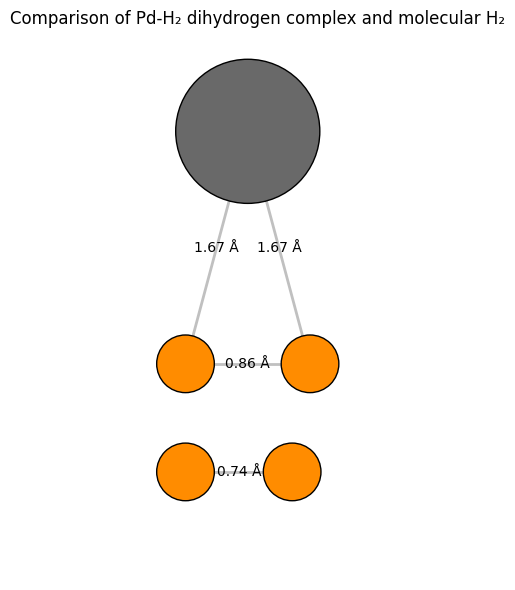

In [24]:
def draw_bond(ax, pos1, pos2, color='silver', width=2):
    """Draw a bond between two points."""
    ax.plot(
        [pos1[0], pos2[0]],
        [pos1[1], pos2[1]],
        color=color, linewidth=width, zorder=1,
    )

def annotate_bond(ax, pos1, pos2, bond_length, color='black'):
    """Annotate a bond with its length."""
    mid_x = (pos1[0] + pos2[0]) / 2  # Midpoint x
    mid_y = (pos1[1] + pos2[1]) / 2  # Midpoint y
    ax.text(
        mid_x, mid_y, f"{bond_length:.2f} Å", color=color, fontsize=10,
        ha='center', va='center', zorder=3
    )

# Define atomic positions
positions_h2 = [(0, -0.75), (0.74, -0.75)]  # H2 molecule (H-H bond = 0.74 Å)
positions_h2_pd = [
    (0, 0), 
    (0.864, 0), 
    (0.432, np.sqrt(1.67**2 - 0.432**2))  # H2-Pd complex (Pd at y ≈ 1.61)
]

# Define atom radii and colors
atom_colors = {'H': 'darkorange', 'Pd': 'dimgrey'}
atom_radii = {'H': 0.2, 'Pd': 0.5}

# Create a single plot
fig, ax = plt.subplots(figsize=(6, 6))

# Plot Molecular H2 (below)
for pos in positions_h2:
    circle = plt.Circle(pos, atom_radii['H'], color=atom_colors['H'], ec='black', zorder=2)
    ax.add_artist(circle)
draw_bond(ax, positions_h2[0], positions_h2[1])
annotate_bond(ax, positions_h2[0], positions_h2[1], bond_length=0.74)

# Plot H2-Pd Complex (above)
for i, pos in enumerate(positions_h2_pd):
    element = 'Pd' if i == 2 else 'H'
    circle = plt.Circle(pos, atom_radii[element], color=atom_colors[element], ec='black', zorder=2)
    ax.add_artist(circle)
draw_bond(ax, positions_h2_pd[0], positions_h2_pd[1])  # H-H bond
draw_bond(ax, positions_h2_pd[0], positions_h2_pd[2])  # Pd-H1 bond
draw_bond(ax, positions_h2_pd[1], positions_h2_pd[2])  # Pd-H2 bond

# Annotate bonds in H2-Pd Complex
annotate_bond(ax, positions_h2_pd[0], positions_h2_pd[1], bond_length=0.864)  # H-H bond
annotate_bond(ax, positions_h2_pd[0], positions_h2_pd[2], bond_length=1.67)  # Pd-H1
annotate_bond(ax, positions_h2_pd[1], positions_h2_pd[2], bond_length=1.67)  # Pd-H2

# Adjust aesthetics
ax.set_xlim(-1, 2)
ax.set_ylim(-1.5, 2.3)
ax.set_aspect('equal')
ax.axis('off')  # Remove axis ticks and labels

plt.title("Comparison of Pd-H₂ dihydrogen complex and molecular H₂")
plt.tight_layout()
plt.show()

When a hydrogen molecule approaches a palladium surface, however, the situation is more involved. For example, some molecules will actually be repelled by the surface if their $\rm H_2$ bond is not aligned with the surface or they have too much rotational energy.

For those molecules that are not repelled, the first thing that happens is a process called ["adsorption"](https://en.wikipedia.org/wiki/Adsorption) which is just a fancy way of saying a particle sticks to the surface of something. Adsorption can involve new chemical bonds being formed (as in [chemisorption](https://en.wikipedia.org/wiki/Chemisorption)) but it can also involve less change to the atoms and molecules (as in [physisorption](https://en.wikipedia.org/wiki/Physisorption)).

For a hydrogen molecule approaching a palladium surface, the type of adsorption and the resulting dynamics depends on many factors including (but not limited to):
- the specific [crystallographic surface orientation](https://chem.libretexts.org/Bookshelves/Physical_and_Theoretical_Chemistry_Textbook_Maps/Surface_Science_(Nix)/01%3A_Structure_of_Solid_Surfaces/1.03%3A_Surface_Structures-_fcc_Metals) of palladium (designated via the [Miller indices](https://en.wikipedia.org/wiki/Miller_index))
- the orientation of the molecule in relation to the surface
- the linear and rotational kinetic energy of the molecule
- the coverage of hydrogen already on the surface

At temperatures around 300K the "sticking probability" is about 75%  (see Fig 12 of [Lischka and Groß](https://webcf.waybackmachine.org/web/20240416071103/https://www.uni-ulm.de/fileadmin/website_uni_ulm/nawi.inst.250/publications/HPd_review.pdf)). This probability is reduced by rapid rotation because the molecule is not aligned for a sufficiently long time for sticking to occur. The reduction is not significant enough for us to consider as part of our first simulation because about 95% of the molecules have rotational states with quantum number $J\le 2$ (see Appendix) which don't show a significant reduction of sticking probability (see Fig. 3 of [ Groß et. al](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.75.2718)).

The interaction of $\rm Pd$ and $\rm H_2$ is a bit special because the attraction is strong enough to allow [dissociative adsorption](https://en.wikipedia.org/wiki/Dissociative_adsorption) in which the $\rm H_2$ molecule splits apart into atomic hydrogen which finds its way into specific spaces in between the surface palladium. This happens even in non-ideal conditions because at typical temperatures, the molecules are moving slowly enough so that they can be very efficiently "dynamically steered" towards a favorable configurations for dissociation.

For our lattice (visualised in birds eye view below), we are working with a specific crystallographic surface orientation that's known as as $\rm Pd(100)$. The final destination for the dissociated hydrogen atoms are the "hollow" sites and the "bridge" sites. Hollow sites are preferred because they are particularly stable positions and can be thought of as traps into which the hydrogen will largely stay stuck.

Later on (when the hollow sites are largely occupied) the bridge sites can become occupied and ["absorption"](https://en.wikipedia.org/wiki/Absorption_%28chemistry%29) occurs - where the particles diffuse into and through the bulk of the material. For the purpose of our simulation, we're going to stop at the adsorption phase; absorption and diffusion are handled by another simulation.





<img src="https://zacros.org/images/tutorial_pics/tut005_fig01.png" alt="Pd(100) surface" width="600">

We'll focus our attention initially on the "atop" positions since these are the most attractive to a hydrogen molecule where they form a state that is closely related to the dihydrogen complex. We'll mock up a kind of manual dynamical steering in which a molecule is gradually aligned with the surface when it gets close enough. We'll do this with a linear interpolation.

Once the molecule is at the atop position, we then need capture the fact that this configuration is not stable. The $\rm H_2$ molecule will ultimately dissociate because it can still reduce its energy by moving its center of mass laterally away from the on-top position - in a sense sliding off the top of the $\rm Pd$ atom and towards the more energetically favourable hollow and bridge sites. We'll also mock up the dissociation motion using linear interpolation.

Let's create the interpolation function.

In [25]:
def interpolate(current_position, current_properties, target_position, target_properties, damping_factor=0.1, threshold=0.01):
    """
    Interpolate the position and properties of a molecule toward a target position and properties.

    Parameters:
    ----------
    current_position : tuple
        Current position of the molecule's centre of mass in the format ('species', x, y, z).

    current_properties : dict
        Current properties of the molecule:
        {
            "bond_length": float,  # Current bonding length
            "theta": float,        # Current polar angle in radians
            "phi": float           # Current azimuthal angle in radians
        }

    target_position : tuple
        Target position of the molecule's centre of mass in the format ('species', x, y, z).

    target_properties : dict
        Target properties of the molecule:
        {
            "bond_length": float,  # Target bonding length
            "theta": float,        # Target polar angle in radians
            "phi": float           # Target azimuthal angle in radians
        }

    damping_factor : float, optional
        Factor to reduce velocity as the molecule approaches the target (default is 0.1).

    threshold : float, optional
        Distance below which the molecule snaps to the target position (default is 0.01 crystal units).

    Returns:
    -------
    tuple
        Updated position and properties of the molecule:
        - new_position : tuple
            Updated position in the format ('species', x, y, z).
        - updated_properties : dict
            A dictionary containing the updated bonding length, polar angle (theta), and azimuthal angle.
    """
    species, x, y, z = current_position
    _, target_x, target_y, target_z = target_position

    # Extract current and target properties
    current_bond_length = current_properties["bond_length"]
    current_theta = current_properties["theta"]
    current_phi = current_properties["phi"]

    target_bond_length = target_properties["bond_length"]
    target_theta = target_properties["theta"]
    target_phi = target_properties["phi"]

    # Calculate displacement vector
    dx = target_x - x
    dy = target_y - y
    dz = target_z - z

    # Distance to target
    distance = np.sqrt(dx**2 + dy**2 + dz**2)

    # If within the threshold, snap to target and set properties
    if distance < threshold:
        return (species, target_x, target_y, target_z), target_properties

    # Calculate new position by moving fraction towards target
    new_x = x + dx * damping_factor
    new_y = y + dy * damping_factor
    new_z = z + dz * damping_factor

    # Update properties by moving fraction towards target
    new_bond_length = current_bond_length + (target_bond_length - current_bond_length) * damping_factor
    new_theta = current_theta + (target_theta - current_theta) * damping_factor

    # Adjust phi difference to shortest path
    phi_difference = target_phi - current_phi
    phi_difference = (phi_difference + np.pi) % (2 * np.pi) - np.pi  # Wrap to [-π, π]

    new_phi = current_phi + phi_difference * damping_factor
    new_phi = new_phi % (2 * np.pi)  # Normalize to [0, 2π]

    # Return the updated position and properties
    updated_properties = {
        "bond_length": new_bond_length,
        "theta": new_theta,
        "phi": new_phi
    }
    return (species, new_x, new_y, new_z), updated_properties


Now we'll create a function that checks to see whether a gas molecule should start adsorbing or not. This is based on how close the molecule is to the atop position and a 75% sticking probability (which we'll reduce for molecules note aligned with the surface). We'll need to not only check how close the gas molecule is to the surface but also keep track of which $\rm Pd$ atoms are already undergoing a bonding process with a molecule - we will make a molecule reflect off these so that we don't end up with two molecules trying to adsorb to the same surface $\rm Pd$.

In [26]:
def adsorb_atop(atom_position, atom_velocity, atom_theta, surface_pd_atoms, bonding_pd_positions):
    """
    Determine if a gas atom should start adsorbing with or reflect off a Pd surface atom based on proximity and orientation.

    Parameters:
    ----------
    atom_position : tuple
        The current position of the atom in the format ('H', x, y, z), where:
        - 'H' represents the atom type.
        - x, y, z are the spatial coordinates in crystal units.

    atom_velocity : tuple
        The current velocity of the atom in the format (vx, vy, vz), where:
        - vx, vy, vz are the velocity components in crystal units per second.

    atom_theta : float
        The orientation angle of the molecule in radians, where:
        - 0 aligns perpendicular to the surface (least likely to adsorb).
        - pi/2 aligns parallel to the surface (most likely to adsorb).

    surface_pd_atoms : list
        A list of Pd atom positions on the surface in the format [('Pd', x, y, z), ...], where:
        - 'Pd' represents the atom type.
        - x, y, z are the spatial coordinates in crystal units.

    bonding_pd_positions : list
        A list of Pd atom positions already bonding with H atoms in the format [('Pd', x, y, z), ...].

    Returns:
    -------
    tuple
        A tuple describing the updated state of the atom:
        - atom_position : tuple
            The current position of the atom ('H', x, y, z).
        - atom_velocity : tuple
            The updated velocity of the atom (vx, vy, vz).
        - bonding_pd_atom : tuple or None
            The Pd atom the H atom is bonding with, or None if no bonding occurs.
    """
    _, x, y, z = atom_position
    vx, vy, vz = atom_velocity

    # Define thresholds
    adsorption_threshold = 0.5  # Distance threshold for adsorption (in crystal units)
    reflection_threshold = 0.5  # Distance threshold for reflection (in crystal units)

    for pd_atom in surface_pd_atoms:
        pd_type, pd_x, pd_y, pd_z = pd_atom

        # Calculate distance to Pd atom
        distance = np.sqrt((x - pd_x) ** 2 + (y - pd_y) ** 2 + (z - pd_z) ** 2)

        if pd_atom not in bonding_pd_positions:
            # Check for adsorption (if Pd is available for bonding)
            if distance < adsorption_threshold:
                # Calculate adsorption probability based on theta
                adsorption_probability = max(0, 0.75 * np.sin(atom_theta))
                if np.random.random() < adsorption_probability:
                    return atom_position, atom_velocity, pd_atom
                else:
                    # Reflect if adsorption probability does not hold
                    reflected_velocity = (-vx, -vy, -vz)  # TODO: Implement realistic reflection logic
                    return atom_position, reflected_velocity, None
        else:
            # Check for reflection (if Pd is unavailable for bonding)
            if distance < reflection_threshold:
                reflected_velocity = (-vx, -vy, -vz)  # TODO: Implement realistic reflection logic
                return atom_position, reflected_velocity, None

    # No adsorbing or reflection
    return atom_position, atom_velocity, None


After the molecule gets adsorbed, we'll start the dissociation process. For this, we need to be able to to identify the bridge and hollow sites.

In [27]:
def identify_bridge_and_hollow_sites(surface_pd_atoms):
    """
    Identify bridge and hollow sites on an FCC (100) surface without duplicates.

    Parameters:
    ----------
    surface_pd_atoms : list of tuples
        List of Pd atom positions in the format [('Pd', x, y, z), ...].

    Returns:
    -------
    tuple
        - bridge_sites: List of positions of bridge sites in the format [('bridge', x, y, z), ...].
        - hollow_sites: List of positions of hollow sites in the format [('hollow', x, y, z), ...].
    """
    # Lattice constant in crystal units
    lattice_constant = 1  # (crystal units)
    nearest_neighbor_distance =  np.sqrt(2*lattice_constant**2) / 2  # Distance for bridge sites
    hollow_distance = lattice_constant  # Distance for hollow sites

    # Extract Pd positions (remove atom type label)
    pd_positions = np.array([np.array(pos[1:]) for pos in surface_pd_atoms])  # Extract positions as numpy array

    # Use sets to avoid duplicates
    bridge_sites_set = set()
    hollow_sites_set = set()

    # Iterate over pairs of Pd atoms
    for atom1, atom2 in combinations(pd_positions, 2):
        distance = np.linalg.norm(atom1 - atom2)

        # Check for bridge site (midpoint of nearest neighbors)
        if np.isclose(distance, nearest_neighbor_distance, atol=1e-2):
            midpoint = tuple((atom1 + atom2) / 2)  # Convert to tuple for hashing
            bridge_sites_set.add(('Bridge', *midpoint))

        # Check for hollow site (midpoint of atoms at lattice_constant distance)
        elif np.isclose(distance, hollow_distance, atol=1e-2):
            midpoint = tuple((atom1 + atom2) / 2)  # Convert to tuple for hashing
            hollow_sites_set.add(('Hollow', *midpoint))

    # Convert sets back to lists
    bridge_sites = list(bridge_sites_set)
    hollow_sites = list(hollow_sites_set)

    return bridge_sites, hollow_sites


Let's check it works

In [28]:
bridge_sites, hollow_sites = identify_bridge_and_hollow_sites(surface_pd_atoms)
plot_lattice(surface_pd_atoms+bridge_sites+hollow_sites, marker_color_map={"Bridge":"orange", "Hollow":"red"})

We're going to need to have ways of easily finding the bridge sites and the hollow sites, so we will create some dictionaries:
- `atom_to_bridges` - returns the bridges associated with an atom
- `bridge_to_atoms` - returns the atoms neighbouring a bridge
- `bridge_to_hollows` - returns the hollows neighbouring a bridge
- `hollow_to_bridge` - returns the bridges neighbouring a hollow

In [29]:
def construct_site_dictionaries(surface_pd_atoms, bridge_sites, hollow_sites):
    """
    Construct dictionaries mapping Pd atoms to bridge sites (and the reverse), bridge sites to hollow sites (and the reverse).

    Parameters:
    ----------
    surface_pd_atoms : list of tuples
        List of Pd atom positions in the format [('Pd', x, y, z), ...].

    bridge_sites : list
        List of bridge sites in the format [('Bridge', x, y, z), ...].

    hollow_sites : list
        List of hollow sites in the format [('Hollow', x, y, z), ...].

    Returns:
    -------
    tuple
        - atom_to_bridges: A dictionary where keys are Pd atom positions in the format ('Pd', x, y, z),
          and values are lists of neighbouring bridge sites in the format [('Bridge', x, y, z), ...].
        - bridge_to_atoms: A dictionary where keys are bridge site positions in the format ('Bridge', x, y, z),
          and values are lists of neighbouring Pd atom sites in the format [('Pd', x, y, z), ...].
        - bridge_to_hollows: A dictionary where keys are bridge site positions in the format ('Bridge', x, y, z),
          and values are lists of neighbouring hollow sites in the format [('Hollow', x, y, z), ...].
        - hollow_to_bridges: A dictionary where keys are hollow site positions in the format ('Hollow', x, y, z),
          and values are lists of neighbouring bridge sites in the format [('Bridge', x, y, z), ...].
    """

    # Lattice constant in crystal units
    lattice_constant = 1  # (crystal units)
    atom_to_bridge_distance =  np.sqrt(2*lattice_constant**2) / 4  # Distance from atom to bridge 
    bridge_to_hollow_distance = np.sqrt(2*lattice_constant**2) / 4  # Distance from atom to hollow

    pd_positions = [np.array(pos[1:]) for pos in surface_pd_atoms]

    # Construct atom_to_bridges sites dictionary
    atom_to_bridges = {}
    for atom in surface_pd_atoms:
        atom_pos = np.array(atom[1:])
        bridges = [
            bridge for bridge in bridge_sites
            if np.isclose(np.linalg.norm(atom_pos - np.array(bridge[1:])), atom_to_bridge_distance, atol=1e-2)
        ]
        atom_to_bridges[atom] = bridges

    # Construct bridge_to_atoms sites dictionary
    bridge_to_atoms = {}
    for bridge in bridge_sites:
        bridge_pos = np.array(bridge[1:])
        atoms = [
            atom for atom in surface_pd_atoms
            if np.isclose(np.linalg.norm(bridge_pos - np.array(atom[1:])), atom_to_bridge_distance, atol=1e-2)
        ]
        bridge_to_atoms[bridge] = atoms

    # Construct bridge_to_hollows sites dictionary
    bridge_to_hollows = {}
    for bridge in bridge_sites:
        bridge_pos = np.array(bridge[1:])
        hollows = [
            hollow for hollow in hollow_sites
            if np.isclose(np.linalg.norm(bridge_pos - np.array(hollow[1:])), bridge_to_hollow_distance, atol=1e-2)
        ]
        bridge_to_hollows[bridge] = hollows

    # Construct hollow_to_bridges sites dictionary
    hollow_to_bridges = {}
    for hollow in hollow_sites:
        hollow_pos = np.array(hollow[1:])
        bridges = [
            bridge for bridge in bridge_sites
            if np.isclose(np.linalg.norm(hollow_pos - np.array(bridge[1:])), bridge_to_hollow_distance, atol=1e-2)
        ]
        hollow_to_bridges[hollow] = bridges

    return atom_to_bridges, bridge_to_atoms, bridge_to_hollows, hollow_to_bridges, 


Let's check it works.

In [30]:
atom_to_bridges, bridge_to_atoms, bridge_to_hollows, hollow_to_bridges = construct_site_dictionaries(surface_pd_atoms, bridge_sites, hollow_sites)

In [31]:
plot_lattice(surface_pd_atoms + atom_to_bridges[('Pd', 0.5, 0.5, 0.0)] + atom_to_bridges[('Pd', 2.0, 3.0, 0.0)] +
             atom_to_bridges[('Pd', 2.0, 1.0, 0.0)], marker_color_map={"Bridge":"orange"})

In [32]:
plot_lattice(surface_pd_atoms  + atom_to_bridges[('Pd', 2.0, 3.0, 0.0)] + bridge_to_hollows[atom_to_bridges[('Pd', 2.0, 3.0, 0.0)][0]]
             +[atom_to_bridges[('Pd', 1.0, 1.0, 0.0)][0]] + bridge_to_hollows[atom_to_bridges[('Pd', 1.0, 1.0, 0.0)][0]], marker_color_map={"Bridge":"orange", "Hollow":"red"})

The most tricky bit now is to figure out where a $\rm H_2$ molecule should dissociate to once it's finished adsorbing to a surface $\rm Pd$. Hollows come first, followed by bridges and once they are filled then no dissociation can occur. In order to prevent multiple occupation of a given site, we have to keep track of what's already been occupied. It's a bit tricky because atoms share bridges and bridges share hollows. 

In [33]:
def calculate_dissociation_target(
    pd_atom, 
    atom_to_bridges,
    bridge_to_atoms,
    bridge_to_hollows, 
    hollow_to_bridges,
    species="H2"
):
    """
    Calculate the dissociation target position and properties for a molecule.

    Parameters:
    ----------
    pd_atom : tuple
        Position of the Pd atom that the molecule is currently adsorbed to at the atop positions ('Pd', x, y, z).

    atom_to_bridges : dict
        Dictionary mapping Pd atoms to their neighbouring bridge sites:
        {('Pd', x, y, z): [('Bridge', x1, y1, z1), ...]}.

    bridge_to_atoms : dict
        Dictionary mapping bridge sites to their neighbouring Pd atom sites:
        {('Bridge', x, y, z): [('Pd', x1, y1, z1), ('Pd', x2, y2, z2)]}.

    bridge_to_hollows : dict
        Dictionary mapping bridge sites to their neighbouring hollow sites:
        {('Bridge', x, y, z): [('Hollow', x1, y1, z1), ('Hollow', x2, y2, z2)]}.

    hollow_to_bridges : dict
        Dictionary mapping hollow sites to their neighbouring bridge sites:
        {('Hollow', x, y, z): [('Bridge', x1, y1, z1), ('Bridge', x2, y2, z2)]}.

    species : str, optional
        The chemical formula for the molecule. Default is "H2".

    Returns:
    -------
    tuple
        - dict : Target information containing:
            - "position": tuple
                Target position of the molecule in the format ('species', x, y, z).
            - "properties": dict
                Target properties of the molecule:
                {
                    "bond_length": float,  # Target bonding length
                    "theta": float,        # Polar angle in radians
                    "phi": float           # Azimuthal angle in radians
                }
        - atom_to_bridges : dict
            Updated sites dictionary.
        - bridge_to_hollows : dict
            Updated sites dictionary.
    """
    pd_coordinates = np.array(pd_atom[1:])  # Remove species label

    if pd_atom not in atom_to_bridges or not atom_to_bridges[pd_atom]:
        # Return null if no bridge sites are available for this Pd atom
        return None, atom_to_bridges, bridge_to_hollows

    bridge_sites = atom_to_bridges[pd_atom]
    random.shuffle(bridge_sites)  # Shuffle the bridge sites to randomize order

    selected_bridge = None
    target_properties = None

    # Iterate through bridge sites
    for bridge in bridge_sites:
        if bridge not in bridge_to_hollows:
            continue

        hollow_sites = bridge_to_hollows[bridge]

        # Use this bridge site
        selected_bridge = bridge
        # Take the two hollow sites (always 2 per bridge)
        hollow1, hollow2 = hollow_sites
        hollow_coordinates = [np.array(hollow[1:]) for hollow in [hollow1, hollow2]]

        # Calculate the bond length as the distance between the two hollow sites
        bond_length = np.linalg.norm(hollow_coordinates[0] - hollow_coordinates[1])

        # Determine the direction of the bond (phi angle)
        dx, dy = hollow_coordinates[0][0] - hollow_coordinates[1][0], hollow_coordinates[0][1] - hollow_coordinates[1][1]
        phi = np.arctan2(dy, dx)

        # Define target properties
        target_properties = {
            "bond_length": bond_length,
            "theta": np.pi / 2,  # Align parallel to the surface
            "phi": phi
        }

        target_position = (species, *np.array(selected_bridge[1:]))

        # Now we need to remove the bridge sites around the two hollows so that no other 
        # molecule will be able to move to those bridges and dissociate to the two hollow sites
        for hollow in hollow_sites:
            # Get the bridge sites associated with this hollow
            neighboring_bridges = hollow_to_bridges[hollow]
    
            # Remove these neighboring bridges from bridge_to_hollows
            for neighboring_bridge in neighboring_bridges:
                if neighboring_bridge in bridge_to_hollows:
                    del bridge_to_hollows[neighboring_bridge]
        
        break

    if selected_bridge is None:
        if len(bridge_sites) < 2:
            # This will be the corner atoms that have already filled up the neighbouring hollow sites
            # They cannot have a dissociated molecule sending the atoms to the bridge sites because
            # corner atoms only have one bridge. In this case, no dissociation can occur
            return None, atom_to_bridges, bridge_to_hollows

        else:
            # Take the first two bridge sites (remember they are randomly shuffled at the start)
            selected_bridge_sites = bridge_sites[:2]
            selected_bridge_coordinates = [np.array(bridge[1:]) for bridge in selected_bridge_sites]
    
            # Calculate the bond length as the distance between the two bridge sites
            bond_length = np.linalg.norm(selected_bridge_coordinates[0] - selected_bridge_coordinates[1])

            # target is midpoint between the bridge points
            midpoint = tuple((selected_bridge_coordinates[0] + selected_bridge_coordinates[1]) / 2) 
            target_position = (species, *midpoint)
    
            # Determine the direction of the bond (phi angle)
            dx, dy = selected_bridge_coordinates[0][0] - selected_bridge_coordinates[1][0], selected_bridge_coordinates[0][1] - selected_bridge_coordinates[1][1]
            phi = np.arctan2(dy, dx)
    
            target_properties = {
                "bond_length": bond_length,
                "theta": np.pi / 2,
                "phi": phi
            }

    
            # Now we need to remove the atom site so that no other molecule will be able to use them
            if selected_bridge in bridge_to_atoms:
                # Get the Pd atom sites neighbouring to this bridge
                neighboring_atoms = bridge_to_atoms[selected_bridge]
                
                # Remove these neighboring atoms from atom_to_bridges to mark them as unavailable
                for atom in neighboring_atoms:
                    if atom in atom_to_bridges:
                        # Remove the selected bridge from the atom's list of bridges
                        if selected_bridge in atom_to_bridges[atom]:
                            atom_to_bridges[atom].remove(selected_bridge)
                        
                        # If the atom has no more bridges available, remove the atom from the dictionary
                        if not atom_to_bridges[atom]:
                            del atom_to_bridges[atom]
    
            # Now we need to remove the bridge sites from all atoms so that that no other 
            # molecules will be able to dissociate into those bridge sites
            for bridge in selected_bridge_sites:
                # Get the atom sites associated with this bridge (there will be two)
                neighboring_atoms = bridge_to_atoms[bridge]
                for neighboring_atom in neighboring_atoms:
                    # Remove the selected bridge from the atom's list of bridges
                    if bridge in atom_to_bridges[neighboring_atom]:
                        atom_to_bridges[neighboring_atom].remove(bridge)
                    
                    # If the atom has no more bridges available, remove the atom from the dictionary
                    if not atom_to_bridges[neighboring_atom]:
                        del atom_to_bridges[neighboring_atom]



    return {
        "position": target_position,
        "properties": target_properties
    }, atom_to_bridges, bridge_to_hollows


## Simulation

We're going to simulate $\rm H_2$ gas molecules adsorbing and dissociating on a $\rm Pd$ surface. We'll do this by moving around the centre of mass of the molecule and we'll keep track of the distance between each $\rm H$ atom (which we'll call the bond length) and the orientation of the molecule in order to allow us to visualise the individual atoms later on. We'll store all this information for each $\rm H_2$ molecule for time-step in arrays which will have names ending in `over_time`. For example, `h_gas_positions_over_time[0]` will give the positions of the centre of mass of the $\rm H_2$ molecule at the start of the simulation and `h_gas_positions_over_time[5]` will give the positions at time $5\Delta t$. We'll do the same for the $\rm Pd$ atoms for consistency even though strictly it's unnecessary because the atoms are unchanging over time.

We will therefore need a function that will expand the centre of mass positions of $\rm H_2$ into the positions of the individual atoms.

In [34]:
def expand_diatomic_positions(
    diatomic_positions_over_time,
    bond_lengths_over_time,
    theta_over_time,
    phi_over_time,
    z_threshold=1e-6
):
    """
    Expand diatomic molecule centre of mass positions into individual atomic positions, 
    considering bond lengths and 3D orientations. Small `z` values are set to zero if below a threshold to avoid visulisation issues.

    Parameters:
    ----------
    diatomic_positions_over_time : list
        List of lists of diatomic molecule centre of mass positions over time, in the format [('H2', x, y, z), ...].

    bond_lengths_over_time : list
        List of lists of bond lengths for each diatomic molecule over time.

    theta_over_time : list
        List of lists of polar angles (theta) for each diatomic molecule over time.

    phi_over_time : list
        List of lists of azimuthal angles (phi) for each diatomic molecule over time.

    z_threshold : float, optional
        Values of `z` with absolute magnitude below this threshold will be set to zero. Default is 1e-6.

    Returns:
    -------
    expanded_positions_over_time : list
        List of lists of individual atomic positions for all diatomic molecules over time, expanded into individual atoms.

    Example:
    -------
    >>> diatomic_positions_over_time = [[('H2', 1.0, 1.0, -1.0)]]
    >>> bond_lengths_over_time = [[0.74]]
    >>> theta_over_time = [[np.pi/2]]
    >>> phi_over_time = [[0]]
    >>> expand_diatomic_positions(diatomic_positions_over_time, bond_lengths_over_time, theta_over_time, phi_over_time)
    [[('H', 1.0, 1.37, -1.0), ('H', 1.0, 0.63, -1.0)]]
    """
    expanded_positions_over_time = []

    for time_index, (positions, bond_lengths, theta_angles, phi_angles) in enumerate(
        zip(diatomic_positions_over_time, bond_lengths_over_time, theta_over_time, phi_over_time)
    ):
        positions_expanded = []

        for com, bond_length, theta, phi in zip(positions, bond_lengths, theta_angles, phi_angles):
            species, x, y, z = com  # Extract the centre of mass species and position

            # Infer individual atom species (e.g., 'H2' → 'H', 'D2' → 'D')
            atom_species = species[:-1]  # Remove the trailing '2'

            # Convert spherical coordinates to Cartesian unit vector
            dx = (bond_length / 2) * np.sin(theta) * np.cos(phi)
            dy = (bond_length / 2) * np.sin(theta) * np.sin(phi)
            dz = (bond_length / 2) * np.cos(theta)

            # Calculate the positions of the two atoms
            atom1_position = (atom_species, x + dx, y + dy, z + dz)
            atom2_position = (atom_species, x - dx, y - dy, z - dz)

            # Adjust small z values to zero
            atom1_position = (
                atom1_position[0],
                atom1_position[1],
                atom1_position[2],
                0 if abs(atom1_position[3]) < z_threshold else atom1_position[3]
            )
            atom2_position = (
                atom2_position[0],
                atom2_position[1],
                atom2_position[2],
                0 if abs(atom2_position[3]) < z_threshold else atom2_position[3]
            )

            positions_expanded.extend([atom1_position, atom2_position])

        expanded_positions_over_time.append(positions_expanded)

    return expanded_positions_over_time


Let's try this out with a couple of molecules with different orientations

In [35]:
# two molecules at t=0
h2_positions_over_time = [[("H2",1,1,-1), ("H2",2,2,-1.5)]]
h2_bond_lengths_over_time = [[angstrom_to_crystal(0.74, cell_parameters), angstrom_to_crystal(0.74, cell_parameters)]]
h2_theta_over_time = [[np.pi/2, np.pi/4]] # pi/2 is aligned with the surface, pi/4 is 45 degrees to the surface
h2_phi_over_time = [[0, np.pi/2]] # 0 is alined along x, pi/2 is aligned along y


h_positions_over_time = expand_diatomic_positions(h2_positions_over_time, h2_bond_lengths_over_time, h2_theta_over_time, h2_phi_over_time)

We can plot this using `plot_lattice` by just taking the first element of the `expand_h_positions_over_time` array

In [36]:
fig = plot_lattice(surface_pd_atoms + h_positions_over_time[0])
fig.show()

We'd like to be able to draw bonds between the atoms. For this we'll create a separate array to store start and end points for the bond. We create a separate array instead of just using the expanded $\rm H$ positions because sometimes we'll not want to visualise a bond e.g. when the molecule has dissociated.

In [37]:
def create_bonds_over_time(expanded_positions_over_time):
    """
    Create bonds over time from expanded diatomic positions.

    Parameters:
        expanded_positions_over_time (list): List of lists of expanded H atom positions from expand_diatomic_positions function.
    
    Returns:
        bonds_over_time (list): List of lists of bonds at each time index. Each bond is a list [position_1, position_2].
    """
    bonds_over_time = []

    for positions_at_time in expanded_positions_over_time:
        bonds_at_time = []
        # Iterate over every pair of consecutive positions to form a bond
        for i in range(0, len(positions_at_time), 2):
            # Extract positions and remove species label
            position_1 = positions_at_time[i][1:]  # Remove species label ('H')
            position_2 = positions_at_time[i + 1][1:]  # Remove species label ('H')
            bonds_at_time.append([position_1, position_2])  # Create bond as [position_1, position_2]
        bonds_over_time.append(bonds_at_time)

    return bonds_over_time


In [38]:
bonds_over_time = create_bonds_over_time(h_positions_over_time)

For visualisating the bonds, we can take an existing figure made by `plot_lattice` and add to it.

In [39]:
def add_bonds_to_figure(fig, bonds, bond_color='green', bond_width=2):
    """
    Add bonds to an existing Plotly figure.

    Parameters:
    ----------
    fig : plotly.graph_objects.Figure
        The existing Plotly figure to which the bonds will be added.

    bonds : list of tuples
        A list of bonds, where each bond is represented as a tuple of two positions:
        [(start1, end1), (start2, end2), ...].
        Each position is a tuple (x, y, z).

    bond_color : str, optional
        Color of the bond lines. Default is 'green'.

    bond_width : int, optional
        Width of the bond lines. Default is 2.

    Returns:
    -------
    fig : plotly.graph_objects.Figure
        The updated Plotly figure with bonds added.

    Example:
    -------
    >>> bonds = [
    ...     [(0.5, 0.5, 0.0), (1.0, 1.0, 1.0)],
    ...     [(1.5, 1.5, 1.5), (2.0, 2.0, 2.0)]
    ... ]
    >>> fig = plot_lattice(atom_positions)
    >>> fig = add_bonds_to_figure(fig, bonds)
    >>> fig.show()
    """
    # Initialize lists to store combined bond coordinates
    bond_x, bond_y, bond_z = [], [], []

    for bond in bonds:
        start, end = bond

        # We're going to create a single trace for all bonds for efficiency
        # which means we need to add None to make sure the bonds don't end up
        # all joined together
        bond_x.extend([start[0], end[0], None])
        bond_y.extend([start[1], end[1], None])
        bond_z.extend([start[2], end[2], None])

    # Add a single trace for all bonds
    fig.add_trace(go.Scatter3d(
        x=bond_x,
        y=bond_y,
        z=bond_z,
        mode='lines',
        line=dict(color=bond_color, width=bond_width),
        name='Bonds',
        showlegend=False
    ))

    return fig


In [40]:
add_bonds_to_figure(fig, bonds_over_time[0])

Now, let's build on our plotting functions to animate the motion over time.

In [41]:
def animate_lattice(atoms_over_time, bonds_over_time=None, elements=None, x_range=(-0.5, 3), y_range=(-0.5, 3), z_range=(3, -3), frame_time=500, dt=1e-14, export=False):
    """
    Create a 3D animation of dynamically updating atom positions and bonds.

    Parameters:
    ----------
    atoms_over_time : list
        List of lists containing atom positions for each time step.
        Each inner list represents a single time step and contains tuples of atom data in the format:
        [('Pd', x1, y1, z1), ('H', x2, y2, z2), ...].

    bonds_over_time : list, optional
        List of lists of bonds for each time step.
        Each inner list contains bonds, where each bond is represented as a tuple of two points:
        [[(x1, y1, z1), (x2, y2, z2)], ...]

    elements : list of strings, optional
        The label of the atomic elements that you want to be ploted, e.g. ["Pd", "H"].
        This will be inferred from the atom_positions label if not specified.
        This is useful for cases where you want a legend to show for a particular elements
        even if there is no data provided for it.

    x_range, y_range, z_range : tuple, optional
        Range of the axes in the plot.

    frame_time : int, optional
        Duration of each frame in milliseconds. Default is 500 ms.

    dt : float, optional
        Time step in seconds. Default is 1e-14.

    export : bool, optional
        If True, the plot is configured to autosize for exporting to an HTML file using 
        `fig.write_html("filename.html", auto_play=False)`. If False, the plot is displayed with fixed 
        dimensions (900x700).

    Returns:
    -------
    go.Figure
        A Plotly animation showing atom positions and bonds over time.

    Example:
    -------
    >>> atoms_over_time = [
    ...     [('Pd', 0.0, 0.0, 0.0), ('H', 1.0, 1.0, 1.0)],
    ...     [('Pd', 0.0, 0.0, 0.0), ('H', 1.1, 1.1, 1.1)]
    ... ]
    >>> bonds_over_time = [
    ...     [[(1.0, 1.0, 1.0), (1.5, 1.5, 1.5)]],
    ...     [[(1.1, 1.1, 1.1), (1.6, 1.6, 1.6)]]
    ... ]
    >>> fig = animate_lattice(atoms_over_time, bonds_over_time)
    >>> fig.show()
    """

     # If bonds_over_time is None, create an empty list of bonds for each timestep
    if bonds_over_time is None:
        bonds_over_time = [[] for _ in range(len(atoms_over_time))]

    # Create frames for animation
    frames = []
    for step, (atom_positions, bonds) in enumerate(zip(atoms_over_time, bonds_over_time)):
        # Create the atom positions plot using `plot_lattice`
        fig = plot_lattice(atom_positions, elements=elements, xlim=x_range, ylim=y_range, zlim=z_range, export=export)

        # Add bonds to the figure using `add_bonds_to_figure`
        fig = add_bonds_to_figure(fig, bonds, bond_color='green', bond_width=2)

        # Calculate time in picoseconds
        time_ps = step * dt * 1e12

        # Extract data from the updated figure for the frame
        frame = go.Frame(data=fig.data, name=f'frame{step}', layout=go.Layout(title_text=f"Time: {time_ps:.2f} ps"))
        frames.append(frame)

    # Create the initial figure
    initial_positions = atoms_over_time[0]
    initial_bonds = bonds_over_time[0]

    # Plot the initial positions
    fig = plot_lattice(initial_positions, elements=elements, xlim=x_range, ylim=y_range, zlim=z_range, export=export)

    # Add initial bonds to the figure
    fig = add_bonds_to_figure(fig, initial_bonds, bond_color='green', bond_width=2)

    # Add animation controls and layout
    fig.update_layout(
        updatemenus=[
            {
                'buttons': [
                    {
                        'args': [None, {'frame': {'duration': frame_time, 'redraw': True}, 'fromcurrent': True, 'transition': {'duration': 0}}],
                        'label': 'Play',
                        'method': 'animate'
                    },
                    {
                        'args': [[None], {'frame': {'duration': 0, 'redraw': True}, 'mode': 'immediate', 'transition': {'duration': 0}}],
                        'label': 'Pause',
                        'method': 'animate'
                    }
                ],
                'direction': 'left',
                'pad': {'r': 10, 't': 87},
                'showactive': False,
                'type': 'buttons',
                'x': 0.1,
                'xanchor': 'right',
                'y': 0,
                'yanchor': 'top'
            }
        ],
        title_text=f"Time: 0.00 ps",
    )

    # Add frames to the figure
    fig.frames = frames

    return fig


To test this out, we'll mock up a circular motion for the two molecules we visualsied earlier.

In [42]:
# Constants
num_timesteps = 1000

# Initial conditions for two molecules
initial_positions = [("H2", 1, 1, -1), ("H2", 2, 2, -1.5)]
initial_bond_lengths = [angstrom_to_crystal(0.74, cell_parameters), angstrom_to_crystal(0.74, cell_parameters)]
initial_theta = [np.pi / 2, np.pi / 4]  # Bond angles relative to surface normal
initial_phi = [0, np.pi / 2]  # Orientation in the x-y plane

# Storage for time-varying data
h2_positions_over_time = []
pd_positions_over_time = []
h2_bond_lengths_over_time = []
h2_theta_over_time = []
h2_phi_over_time = []

# Generate data for each times-tep
for t in range(num_timesteps):
    positions = []
    bond_lengths = []
    theta = []
    phi = []

    for i, pos in enumerate(initial_positions):
        # Define the radius of the motion for each molecule
        radius = 0.5 * (i + 1)  # Each molecule has a different radius
    
        # Calculate the center of the circle
        center_x = pos[1]
        center_y = pos[2] - radius  # Shift center to align initial position
    
        # Update position for circular motion
        x = center_x + radius * np.sin(-2 * np.pi * t / num_timesteps)
        y = center_y + radius * np.cos(-2 * np.pi * t / num_timesteps)
        z = pos[3]  # z remains constant

        positions.append(("H2", x, y, z))

        # Bond length remains constant for simplicity
        bond_lengths.append(initial_bond_lengths[i])

        # Bond angles remain constant for simplicity
        theta.append(initial_theta[i])
        phi.append(initial_phi[i])

    h2_positions_over_time.append(positions)
    pd_positions_over_time.append(surface_pd_atoms)
    h2_bond_lengths_over_time.append(bond_lengths)
    h2_theta_over_time.append(theta)
    h2_phi_over_time.append(phi)

We can now expand the molecule into it's atoms, create the bonds and combine the hydrogen and palladium together into a single array for plotting.

In [43]:
h_positions_over_time = expand_diatomic_positions(
    h2_positions_over_time,
    h2_bond_lengths_over_time,
    h2_theta_over_time,
    h2_phi_over_time
)

bonds_over_time = create_bonds_over_time(h_positions_over_time)

all_atoms_over_time = [Hs + Pds for Hs, Pds in zip(h_positions_over_time, pd_positions_over_time)]

In [44]:
animate_lattice(all_atoms_over_time, bonds_over_time,frame_time=5)

We're now in a position to put everything together and visualise $\rm D_2$ gas adsorbing onto a $\rm Pd$ surface.

In [45]:
def simulate(
    pd_atoms,
    cell_parameters,
    num_iterations=30,
    seed=43,
    gas_temperature=25,
    gas_pressure=1,
    dt = 1e-14
):

    # Bond length for D2 gas
    D2_gas_bond_length = angstrom_to_crystal(0.74, cell_parameters)

    # Distance between Pd and the center of mass of a D2 molecule once it has bonded
    Pd_to_D2_center_length = angstrom_to_crystal(np.sqrt(1.67**2 - 0.432**2), cell_parameters)

    # Bond length of D2 when adsorbed to a Pd atop site
    D2_adsorb_bond_length = angstrom_to_crystal(0.864, cell_parameters)

    # Extract the surface Pd so that when we check for D2 proximity to Pd we don't need to waste time checking the bulk Pd
    surface_pd_atoms = [site for site in pd_atoms if site[3] == 0.0]

    # Make the site dicts that allow us to keep track of what sites are occupied
    bridge_sites, hollow_sites = identify_bridge_and_hollow_sites(surface_pd_atoms)
    atom_to_bridges, bridge_to_atoms, bridge_to_hollows, hollow_to_bridges = construct_site_dictionaries(surface_pd_atoms, bridge_sites, hollow_sites)
    
    # Set the random seed
    rng = np.random.default_rng(seed)

    # Constants for gas simulation
    D2_mass = chemical_formula("D2").mass*dalton_to_kg  # mass of D2 in kg

    # Calculate grid limits
    gas_limits = calculate_gas_limits(pd_atoms, 2.0)
    
    # Calculate how many and where the initial gas particles should be taking into account pressure and temperature to 
    # give us density and the using the lattice dimensions to determine how big the simulation space should be into which
    # we'll put the particles. It's very likely that at common temperatures and pressures, there will be less than 1 particle
    # in the simulation box. In that case, a single particle is generated in the box probabilistically. We therefore need
    # to keep calling generate_gas_positions until we get something non-empty so that we at least start with something
    # in the box.
    inital_gas_positions = []
    while not inital_gas_positions:  # Keep trying until positions is non-empty
        inital_gas_positions = generate_gas_positions(gas_pressure, gas_temperature, gas_limits, cell_parameters, "D2", D2_mass)

    # Create an array that will hold the positions of all D2 molecules over all time. Each element of the array will be an array. The
    # current positions will be the last element in the array, i.e. gas_positions_over_time[-1]
    gas_positions_over_time = []
    gas_positions_over_time.append(inital_gas_positions)

    # Generate properties of the gas molecules, specifically, orientation to the surface, and the bond length.
    # This data that will be used to turn the molecule into atoms later
    inital_gas_properties = generate_gas_properties(len(inital_gas_positions), D2_gas_bond_length)

    # Create an array to hold bond length and orientation data
    gas_properties_over_time = []
    gas_properties_over_time.append(inital_gas_properties)

    # Initialise the atom velocities given the temperature and using the cell_parameters in order to convert speed from m/s t0
    # crystal units per second. Note we assume the cell_parameters are the same in all dimensions
    gas_velocities = generate_gas_velocities(len(inital_gas_positions), gas_temperature, cell_parameters, "D2", D2_mass)

    # Initialise an empty array for holding atoms that have entered a region close to the Pd. These atoms are moved in a special way 
    # as they are adsorbed and so will be taken out of the main moving loop.
    adsorbing_positions_over_time = [[]]
    adsorbing_properties_over_time = [[]]

    # Initialise an empty array for holding atoms that are undergoing dissociation. These atoms are moved in a special way 
    # as they are dissociated and so will be taken out of the main moving loop and the adsorbing loop.
    dissociating_positions_over_time = [[]]
    dissociating_properties_over_time = [[]]

    # Keeps track of the Pd atoms that have a D2 currently bonding with them so that D2 that get close to them will just reflect off rather than
    # start bonding
    bonding_pd_positions = []

    # Keeps track of the target positions, bond lengths and orientations for molecules that are undergoing dissociation
    dissociation_targets = []
    
    # Create an array that will hold the positions of all Pd atoms over all time.
    pd_positions_over_time = []

    for cycle in range(num_iterations - 1):
        # Pd are static so we add the initial Pd atoms to pd_positions_over_time
        pd_positions_over_time.append(surface_pd_atoms)
        
        # Grab the current positions velocities and propeties of all the particles
        current_gas_positions = gas_positions_over_time[-1]
        current_adsorbing_positions = adsorbing_positions_over_time[-1]
        current_gas_properties = gas_properties_over_time[-1]
        current_adsorbing_properties = adsorbing_properties_over_time[-1]
        current_dissociating_positions = dissociating_positions_over_time[-1]
        current_dissociating_properties = dissociating_properties_over_time[-1]
        current_gas_velocities = gas_velocities[:] # copy the array

        # Check the density of gas particles. Some might have left the boundary or started bonding, 
        # so we might need to inject some more gas particles to be consistent with the gas pressure.
        # Keep in mind that for typical gas pressures we have <1 particle in our simulation box, so 
        # we'll likely have to wait several time steps before we generate a new particle if one has left

        # Generate all potential gas positions consistent with the target density
        all_potential_gas_positions = generate_gas_positions(gas_pressure, gas_temperature, gas_limits, cell_parameters, "D2", D2_mass)
        all_potential_gas_velocities = generate_gas_velocities(len(all_potential_gas_positions), gas_temperature, cell_parameters, "D2", D2_mass)
        all_potential_gas_properties =  generate_gas_properties(len(all_potential_gas_positions), D2_gas_bond_length)

        
        # Calculate how many more particles are needed to meet the target density
        num_particles_to_inject = max(0, len(all_potential_gas_positions) - len(current_gas_positions))
        
        # If more particles are needed, inject only the required number
        if num_particles_to_inject > 0:
            # Inject the required number of new particles
            new_gas_positions = all_potential_gas_positions[:num_particles_to_inject]
            new_gas_velocities = all_potential_gas_velocities[:num_particles_to_inject]
            new_gas_propeties = all_potential_gas_properties[:num_particles_to_inject]
            # Update the current gas positions
            current_gas_positions += new_gas_positions
            current_gas_velocities += new_gas_velocities
            current_gas_properties += new_gas_propeties
        
        
        # Create a placeholder for the new positions, velocities and gas properties of the particles after we've moved/adsorbed/dissociated them
        gas_positions_over_time.append([])
        gas_properties_over_time.append([])
        gas_velocities = []
        adsorbing_positions_over_time.append([])
        adsorbing_properties_over_time.append([])
        dissociating_positions_over_time.append([])
        dissociating_properties_over_time.append([])

        # Molecules that are already dissociating need to undergo their dissociating motion
        if current_dissociating_positions:
            for molecule, properties, target in zip(current_dissociating_positions, current_dissociating_properties, dissociation_targets):
                # As the dissociation proceeds, the position of the center of the gas molecule and bond length and orientation will change
                new_dissociating_position, new_dissociating_properties = interpolate(molecule, properties, target["position"], target["properties"], damping_factor=0.05)
                # Add the new position and properties of the adsorbing molecule to the new "present"
                dissociating_positions_over_time[-1].append(new_dissociating_position)
                dissociating_properties_over_time[-1].append(new_dissociating_properties)


        # Molecules that are already adsorbing need to undergo their adsorbing motion       
        if current_adsorbing_positions:
            for molecule, properties, pd_atom in zip(current_adsorbing_positions, current_adsorbing_properties, bonding_pd_positions):
                # As the adsorbing proceeds, the position of the center of the gas molecule and bond length and orientation will change
                target_position = ("D2", pd_atom[1], pd_atom[2], pd_atom[3] - Pd_to_D2_center_length)
                target_properties = {"bond_length":D2_adsorb_bond_length, "theta":np.pi/2, "phi":properties["phi"]}
                new_adsorbing_position, new_adsorbing_properties = interpolate(molecule, properties, target_position, target_properties)
                if molecule == new_adsorbing_position:
                    # molecule finished adsorbing, now need to check to see whether it can dissociate.
                    # We need to see if there is a dissociation target at this adsoprtion position
                    dissociation_target, atom_to_bridges, bridge_to_hollows = calculate_dissociation_target(pd_atom, atom_to_bridges, bridge_to_atoms, bridge_to_hollows, hollow_to_bridges, species="D2")
                    if dissociation_target:
                        # move it to the dissociation loop for for the next iteration
                        dissociating_positions_over_time[-1].append(new_adsorbing_position)
                        dissociating_properties_over_time[-1].append(new_adsorbing_properties)
                        # Keep track of the target
                        dissociation_targets.append(dissociation_target)
                        # Remove pd_atom from bonding_pd_positions
                        bonding_pd_positions.remove(pd_atom)

                    else:
                        # if no target it means there are no more hollow or bridge spaces so the molecule cannot dissociate
                        # Add the same position and properties of the adsorbing molecule to the new "present"
                        adsorbing_positions_over_time[-1].append(new_adsorbing_position)
                        adsorbing_properties_over_time[-1].append(new_adsorbing_properties)

                else:
                    # Add the new position and properties of the adsorbing molecule to the new "present"
                    adsorbing_positions_over_time[-1].append(new_adsorbing_position)
                    adsorbing_properties_over_time[-1].append(new_adsorbing_properties)

        # We might not have any gas particles if they have left the simulation box, so we need to check first
        if current_gas_positions:
            for position, velocity, properties in zip(current_gas_positions, current_gas_velocities, current_gas_properties):
                # Move all gas atoms and check boundary conditions.
                # If None is returned for new_gas_position and new_gas_velocity it means particle has left the simulation box
                # and we have no position or velocity to append in the next time step so the molecule vanishes
                new_gas_position, new_gas_velcoity = move_gas_atom(position, velocity, dt, gas_limits)
                
                if(new_gas_position and new_gas_velcoity):
                    # Now check if the newly moved D2 molecule has entered a region where it should start adsorbing.
                    # If a bonding_pd_position is returned then it means this the gas should start adsorbing in the next cycle instead of moving like a gas particle
                    # The adsorb_atop function keeps track of which Pd atoms have already got a D2 molecule bonding with them and reflects any new gas that get close
                    new_gas_position, new_gas_velcoity, bonding_pd_position = adsorb_atop(new_gas_position, new_gas_velcoity, properties["theta"], surface_pd_atoms, bonding_pd_positions)
                    
                    if(bonding_pd_position):
                        # An gas molecule that needs to start adsorbing should be added to the list of atoms that are adsorbing for the next iteration
                        adsorbing_positions_over_time[-1].append(new_gas_position)
                        adsorbing_properties_over_time[-1].append(properties)
                        # Take note of the Pd that has a D2 molecule starting to bond with it so that other D2's will not be able to do so
                        # in the future
                        bonding_pd_positions.append(bonding_pd_position)
                    else:
                        # The particle is still in play so add it to the new "present"
                        gas_positions_over_time[-1].append(new_gas_position)
                        gas_velocities.append(new_gas_velcoity)
                        gas_properties_over_time[-1].append(properties) # no change to bond length or orientation in the gas
    
    # Now we must combine the gas molecules and the adsorbing molecules
    molecule_positions_over_time = [gas + adsorbing for gas, adsorbing in zip(gas_positions_over_time, adsorbing_positions_over_time)]
    molecule_properties_over_time = [gas + adsorbing for gas, adsorbing in zip(gas_properties_over_time, adsorbing_properties_over_time)]

    molecule_bond_lengths_over_time = [[properties["bond_length"] for properties in timestep] for timestep in molecule_properties_over_time]
    molecule_theta_over_time = [[properties["theta"] for properties in timestep] for timestep in molecule_properties_over_time]
    molecule_phi_over_time = [[properties["phi"] for properties in timestep] for timestep in molecule_properties_over_time]

    dissociating_bond_lengths_over_time = [[properties["bond_length"] for properties in timestep] for timestep in dissociating_properties_over_time]
    dissociating_theta_over_time = [[properties["theta"] for properties in timestep] for timestep in dissociating_properties_over_time]
    dissociating_phi_over_time = [[properties["phi"] for properties in timestep] for timestep in dissociating_properties_over_time]

    dissociating_positions_over_time.append([])
    dissociating_properties_over_time.append([])



    # Finally, we must expand the center of mass positions into the positions of each D atom
    molecules_over_time = expand_diatomic_positions(
                                            molecule_positions_over_time,
                                            molecule_bond_lengths_over_time,
                                            molecule_theta_over_time, 
                                            molecule_phi_over_time
                                            )
    
    dissociated_molecules_over_time = expand_diatomic_positions(
                                        dissociating_positions_over_time,
                                        dissociating_bond_lengths_over_time,
                                        dissociating_theta_over_time, 
                                        dissociating_phi_over_time
                                        )
    
    return molecules_over_time, dissociated_molecules_over_time, pd_positions_over_time

In [52]:
D2_positions_over_time, D_positions_over_time, Pd_positions_over_time = simulate(pd_positions, cell_parameters, num_iterations=1000, dt=5e-14)

In [53]:
bonds_over_time = create_bonds_over_time(D2_positions_over_time)

In [54]:
all_atoms_over_time = [D2s + Ds + Pds for D2s, Ds, Pds in zip(D2_positions_over_time, D_positions_over_time, Pd_positions_over_time)]

In [59]:
anim = animate_lattice(all_atoms_over_time, bonds_over_time, frame_time=20, elements=["Pd", "D"], dt=5e-14, export=False)

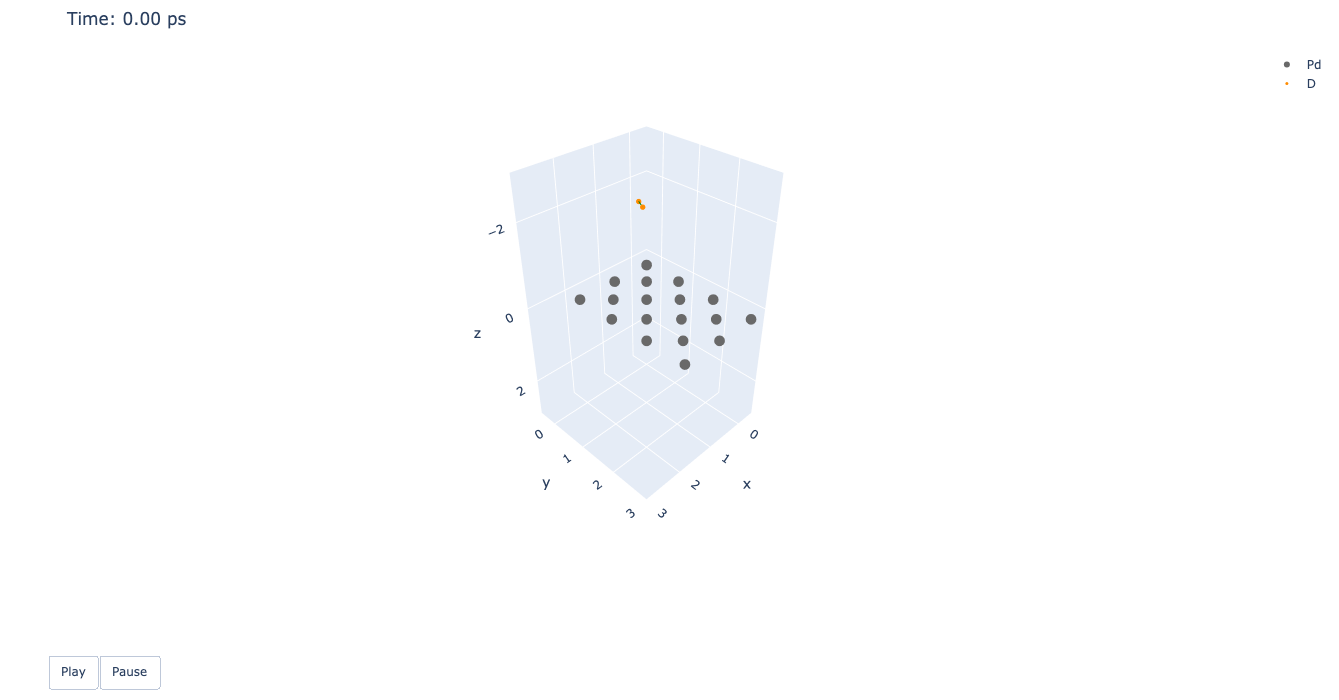

In [60]:
anim.show()
# anim.write_html("D2-adsorption-onto-Pd.html", auto_play=False) # Requires "export=True" in animate_lattice

---

## Appendix: Rotational State Populations for $ \text{H}_2 $ at 300 K

Here we calculates the rotational state populations for $ \text{H}_2 $ at 300 K, using the rigid rotor model and the Boltzmann distribution.

### Theoretical Background

1. **Rotational Energy Levels**:  
   The rotational energy levels for a diatomic molecule in the rigid rotor approximation are:  
   $$ E_J = \frac{\hbar^2}{2I} J(J+1), $$  
   where:
   - $J$ is the rotational quantum number ($J = 0, 1, 2, \dots$),
   - $I$ is the moment of inertia of the molecule,
   - $\hbar$ is the reduced Planck's constant.

2. **Degeneracy**:  
   Each rotational state $J$ has a degeneracy given by:  
   $$ g_J = 2J + 1. $$

3. **Boltzmann Distribution**:  
   The fractional population of molecules in a rotational state $J$ is given by:  
   $$ f_J = \frac{g_J e^{-E_J / k_B T}}{Z}, $$  
   where:
   - $k_B$ is Boltzmann's constant,
   - $T$ is the temperature in kelvin,
   - $Z$ is the rotational partition function:  
     $$ Z = \sum_{J=0}^\infty g_J e^{-E_J / k_B T}. $$

4. **Rotational Constant**:  
   The rotational constant $B$ in terms of the bond length $r_0$ and reduced mass $\mu$ is:  
   $$ B = \frac{\hbar^2}{2I k_B}, \quad I = \mu r_0^2, \quad \mu = \frac{m_1 m_2}{m_1 + m_2}. $$  
   For $ \text{H}_2 $, $ r_0 = 0.074 \, \text{nm} $.

### Implementation
The Python code below calculates the fractional populations and plots the results.


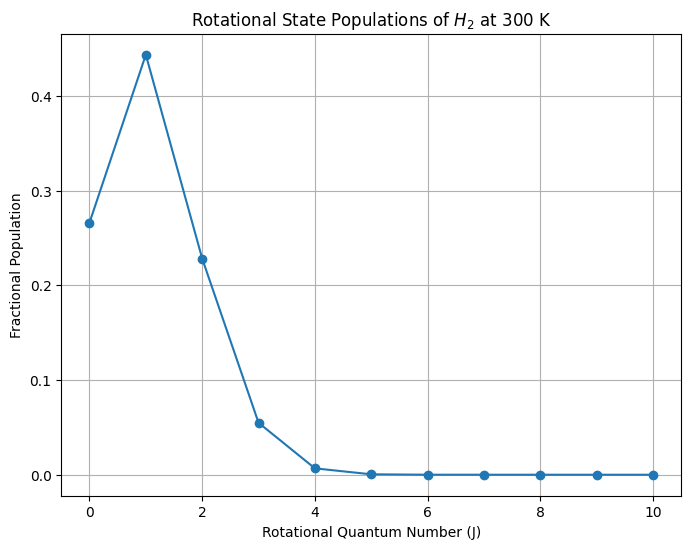

In [51]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
h = 6.626e-34  # Planck's constant (J·s)
hbar = h / (2 * np.pi)  # Reduced Planck's constant (J·s)
k_B = 1.38e-23  # Boltzmann constant (J/K)
T = 300  # Temperature (K)
r0 = 0.074e-9  # Bond length of H2 (m)
m_p = 1.67e-27  # Mass of a proton (kg)
mu = m_p / 2  # Reduced mass of H2 (kg)
I = mu * r0**2  # Moment of inertia (kg·m^2)
B = hbar**2 / (2 * I * k_B)  # Rotational constant (K)

# Calculate rotational partition function and populations
J_max = 10  # Max rotational quantum number for summation
Z = 0  # Rotational partition function
fractions = []  # Fractional populations
J_values = []  # Rotational quantum numbers

for J in range(J_max + 1):
    E_J_kT = B * J * (J + 1) / T  # Energy in units of k_B*T
    g_J = 2 * J + 1  # Degeneracy
    term = g_J * np.exp(-E_J_kT)  # Boltzmann factor
    Z += term  # Add to partition function
    fractions.append(term)
    J_values.append(J)

# Normalize fractions
fractions = [f / Z for f in fractions]

# Plotting the results
plt.figure(figsize=(8, 6))
plt.plot(J_values, fractions, marker='o', linestyle='-')
plt.title("Rotational State Populations of $H_2$ at 300 K")
plt.xlabel("Rotational Quantum Number (J)")
plt.ylabel("Fractional Population")
plt.grid(True)
plt.show()
